In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import cv2
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
# set the correction
correction = 0.25

In [3]:
def read_data(prefix, use_all_cams=True):
    data = []
    with open(prefix + '/driving_log.csv', 'r') as f:
        reader = csv.DictReader(f)
        for log in reader:
            image_center = log['center'].strip()
            image_left = log['left'].strip()
            image_right = log['right'].strip()
            steering = float(log['steering'].strip())
            data.append((image_left, image_center, image_right, steering))

    print("Total Entries: {}".format(len(data)))
    return data

In [4]:
d_train = read_data('data', use_all_cams=False)
np.random.shuffle(d_train)
n_train = int(0.8*len(d_train))
d_valid = d_train[n_train:]
d_train = d_train[:n_train]

print("Num Train: {}, Num Valid {} ".format(len(d_train), len(d_valid)))

Total Entries: 8920
Num Train: 7136, Num Valid 1784 


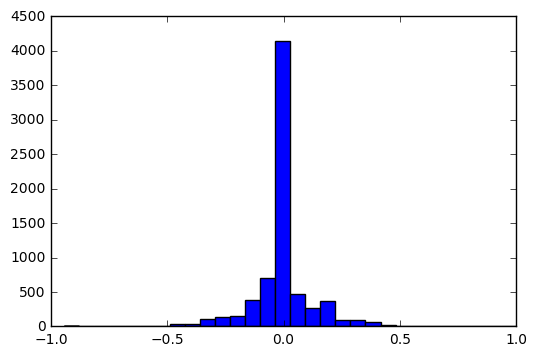

In [5]:
ta = [a for l,c,r,a in d_train]
p = plt.hist(ta, bins=100)

In [6]:
len(d_train)

7136

In [7]:
def brighten(img):
    if np.random.random() < 0.5:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
        img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    return img
        

In [8]:
def load_img(path):
    img = cv2.imread(path)
    img = brighten(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return Image.fromarray(img)

In [9]:
def load_img_rgb(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

In [10]:
def crop_and_resize(img):
    img = img.crop((0,60,img.width,img.height-25))
    img = img.resize((200, 66),resample=Image.BILINEAR)
    return img

In [11]:
def img_to_array(img):
    x = np.asarray(img, dtype='float32')
    return x

In [12]:
# from keras image.py
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

(66, 200, 3)


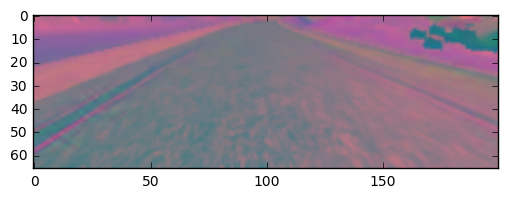

In [13]:
# test
def check(path):
    # path = path.replace('data',prefix)
    img = load_img(path)
    img = crop_and_resize(img)
    return img

prefix='data'
path = os.path.join(prefix, d_train[1][0])
img = check(path)
plt.imshow(img)
x = img_to_array(img)
# x = flip_axis(x, 1)
img_shape = x.shape
print(img_shape)

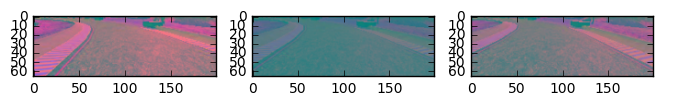

In [14]:
# test
paths = ['data/IMG/left_2017_04_25_21_16_54_426.jpg','data/IMG/center_2017_04_25_21_16_54_426.jpg','data/IMG/right_2017_04_25_21_16_54_426.jpg']
subplots = [131,132,133]
plt.figure(figsize=(8,8))
for i, path in enumerate(paths):
    img = check(path)
    plt.subplot(subplots[i])
    plt.imshow(img)
    

In [15]:
def image_data_generator(data, prefix, train=True, batch_size=32):
    while(1):
        np.random.shuffle(data)
        for start in range(0, (len(data)//batch_size)*batch_size, batch_size):
            current_batch_size = batch_size
            batch_x = np.zeros(tuple([current_batch_size]+list(img_shape)))
            batch_y = np.zeros(current_batch_size)
            for i in range(current_batch_size):
                all_cams = True
                image_file = data[i][1]  # center
                angle = float(data[i][3])
                # get other camera images for training only
                if train and all_cams:
                    choices = ['left','center','center','right']
                    choice = np.random.choice(choices)
                    if choice=='left':
                        image_file = data[i][0]  # left_image
                        angle += correction
                    elif choice=='right':
                        image_file = data[i][2]  # right image
                        angle -= correction
                        
                path = os.path.join(prefix, image_file)
                # load image and convert to YUV
                img = load_img(path)
                # crop and resize
                img = crop_and_resize(img)
                x = img_to_array(img)
                if train:
                    if np.random.random() < 0.5:
                        x = flip_axis(x, 1)
                        angle = -1. * angle
                batch_x[i,:,:,:] = x
                batch_y[i] = angle
                
            yield(batch_x, batch_y)
                
                

In [16]:
batch_size = 64
train_generator = image_data_generator(d_train, 'data', batch_size=batch_size)
valid_generator = image_data_generator(d_valid, 'data', train=False, batch_size=batch_size)

In [17]:
def nvidia_model(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x/255 - 0.5, input_shape=input_shape))
    # model.add(Cropping2D(cropping=((60,25),(0,0))))
    model.add(Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), 
                     activation='relu'))
    model.add(Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), 
                    activation='relu'))
    model.add(Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), 
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), 
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation='elu'))
    return model

In [18]:
# checkpoint
filepath="model-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
early_stopping = EarlyStopping(patience=2)
callbacks_list = [checkpoint, early_stopping]

In [19]:
model = nvidia_model(img_shape)
model.compile(optimizer=Adam(), loss='mse')

In [20]:
#model.load

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=len(d_train)*4//batch_size+1, epochs=10,
                    validation_data=valid_generator, validation_steps = len(d_valid)//batch_size+1,
                    callbacks=callbacks_list)

Epoch 1/10
447/447 [==============================] - 80s - loss: 0.0170 - val_loss: 0.0262
Epoch 2/10
447/447 [==============================] - 79s - loss: 0.0085 - val_loss: 0.0180
Epoch 3/10
447/447 [==============================] - 79s - loss: 0.0080 - val_loss: 0.0179
Epoch 4/10
447/447 [==============================] - 79s - loss: 0.0066 - val_loss: 0.0228
Epoch 5/10
447/447 [==============================] - 79s - loss: 0.0060 - val_loss: 0.0310
Epoch 6/10
447/447 [==============================] - 80s - loss: 0.0052 - val_loss: 0.0342
